#Domestic (US and US territories) Flight Delay Project
## Phase 3
**w261 Final Project Team 19 Summer 2022**

Team Members: Grace Lee, Shivangi Pandey, Sybil Santos-Burgan, Beijing Wu

##Abstract

In this phase, we expand our study predicting flight delays. Our main goal in this phase is to build an initial model that improves on our baseline after doing some feature engineering and cross validation. For feature engineering, we created variables indicating type of airline, holiday periods, prior flight delay, and airport importance. We then created a modeling pipeline and custom rolling window cross validation function for hyperparameter tuning on logistic regression and some tree-based models. We will then evaluate the models against the baseline and will look at feature importance to improve feature selection on future models.

## Introduction & Project Description
- problem: We hope to assist airport planning by predicting departure delays 2 hours before departure. To recap our alternate hypothesis, we belive adding information about tracking prior flights improves prediction of departure delays.
- datasets: We use our joined dataset which contains features from airline, station, and weather data. 
- Tasks: In this phase, we create features, build modeling pipeline, and use cross validation on logistic regression, and begin exploring other models
- metrics: F2, balanced accuracy, MCC

## Data Dictionary
The following data dictionaries are subset from the full data and the following features are present in the joined dataset, chosen by domain knowledge and EDA (see below). 

###### Airlines (Flights) Data: 

| Feature | Description | data type |
| --- | --- | --- |
| DEP_DEL15 | Indicator of departure delay 15 minutes or more. (1 = Yes) | float64 |
| YEAR | Year | int32 |
| QUARTER | Quarter | int32 |
| MONTH | Month | int32 |
| FL_DATE | Flight Date yyyy-mm-dd | string |
| DAY_OF_WEEK | Day of the Week | int32 |
| OP_CARRIER | Airline | string |
| ORIGIN | Origin Airport | string |
| DEST | Destination Airport | string |
| CRS_DEP_TIME | Computer Reservation System scheduled departure time | int32 |
| ARR_DELAY | Difference between scheduled and actual arrival time (in minutes) | float64 |
| DIVERTED | Diverted Flight Indicator (1 = Yes) | float64 |
| TAIL_NUM | Plane tail numbers | string |
| DISTANCE | Distance between airports (miles) | float64 |
| CANCELLED | Cancelled Flight Indicator (1 = Yes) | float64 |

###### Weather Data: 

| Feature | Description | data type |
| --- | --- | --- |
| STATION | Weather station code | string |
| DATE | Weather reading date yyyy-mm-dd hh:mm:ss | string |
| LATITUDE | Latitude of the weather station | float64 |
| LONGITUDE | Longitude of the weather station | float64 |
| NAME | Name of weather station | string |
| REPORT_TYPE |  Code that denotes the type of geophysical surface observation | string |
| OvercastIndex | Overcast weather indicator (0 = No, 1 = Yes) | float64 |
| WindSpeedAvg | Wind speed (in meters per second) averaged over 2-hour window prior to the time indicated | float64 |
| DewPointTempAvg | Dew point temperature (in Degrees Celsius) averaged over 2-hour window prior to the time indicated | float64 |
| VisibilityAvg | Visibility (in meters) averaged over 2-hour window prior to the time indicated | float64 |

###### Stations Data: 
| Feature | Description | data type |
| --- | --- | --- |
| station_id | Weather station code represents base weather station  | string  |
| neighbor_id | Weather station code represents neighboring stations from base station | string |
| neighbor_name | Name of station | string |
| neighbor_call | ICAO airport code | string |
| distance_to_neighbor | Distance from base station. Base station distance is 0. | double |

###### Airport Codes Data: 
| Feature | Description | data type |
| --- | --- | --- |
| ident | ICAO airport code | string |
| type | Type of location | string |
| airport_name | Name | string |
| iata_code | IATA code | string |

## Feature Engineering Summary

|Feature|Description, Source, why we are adding this feature| Feature family|
|---|---|---|
|carrier_cat| Through our previous EDA, we discovered there was a trend of super low cost airlines having higher % of flights delayed, major airlines having less delays, and regional airlines having even less delays. We obtained the carrier categories off of https://www.airlinepilotcentral.com/airlines and https://www.icao.int/sustainability/pages/low-cost-carriers.aspx  | categorical |
|HOLIDAY_IND| holiday seasons may affect delays. This is a binary indicator of flights that occur on a holiday date. The holiday dates were decided based on the air travel industries definitions from the bureau of transportation statistics https://www.transtats.bts.gov/holidaydelay.asp | binary |
|PRE_HOLIDAY_IND| holiday seasons may affect delays. This is a binary indicator of flights that occur prior to a holiday date. The holiday "pre" season length is different depending on the holiday, and was decided based on the air travel industries definitions from the bureau of transportation statistics https://www.transtats.bts.gov/holidaydelay.asp | binary |
|POST_HOLIDAY_IND| holiday seasons may affect delays. This is a binary indicator of flights that occur after a holiday date. The holiday "post" season length is different depending on the holiday, and was decided based on the air travel industries definitions from the bureau of transportation statistics https://www.transtats.bts.gov/holidaydelay.asp | binary |
|PRIOR_FLIGHT_LATE_ARRIVAL| Our hypothesis is that prior flight information will improve prediction of departure delays. This variable is a binary indicator of whether the plane arrived over 30 min late from its previous flight. | binary |
|origin_airport_pagerank| Busy airports may be more likely to have delays. This is a variable indicating the importance of an airport. The values in this feature are the relative pagerank importance of the airport| numeric |

## Notebook Setup

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Window

import time

from scipy import stats
from scipy.stats import norm

pd.options.display.float_format = '{:.0f}'.format
from pyspark.sql.functions import col
from pyspark.sql.functions import col, max

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from pyspark.sql.functions import col,isnan,when,count
from graphframes import *

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.feature import StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from sparkdl.xgboost import XgboostClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import math
import itertools 

#Set up blob access
blob_container = "261finalproject" # The name of your container created in https://portal.azure.com
storage_account = "ssburgan" # The name of your Storage account created in https://portal.azure.com
secret_scope = "261finalprojectscope1" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "bestteam" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

# Inspect the Mount's Final Project folder 
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))


path,name,size,modificationTime
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/,parquet_airlines_data/,0,1656618287000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/,parquet_airlines_data_1y/,0,1656630272000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/,parquet_airlines_data_3m/,0,1656630114000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_6m/,parquet_airlines_data_6m/,0,1656630205000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data/,parquet_weather_data/,0,1656622074000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/,parquet_weather_data_1y/,0,1656631614000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/,parquet_weather_data_3m/,0,1656630651000
dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_6m/,parquet_weather_data_6m/,0,1656631047000
dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/,stations_data/,0,1656713663000


## Load, Transformation and Feature Engineering

In [0]:
#Read in full joined dataset 
df_join = spark.read.parquet(f"{blob_url}/base_datasets/final_joined_data")
print('initial row count:', df_join.count())

# Fill cancelled missing values in delayed column (because missing when flight cancelled, consider cancels as delays)
df_join.na.fill({'DELAYED': 1})

#Read in airline names dataset
df_airline_names = spark.read.parquet(f"{blob_url}/airline_names")
df_airline_names = df_airline_names.withColumnRenamed("Code", "Airline_Code")
df_airline_names = df_airline_names.withColumnRenamed("Description", "Airline_Description")

#Read in carrier cateogry LCC, Regional, Legacy
df_carrier_cat = spark.read.parquet(f"{blob_url}/carrier_cat_US")

#Add Hour Column
df_join = df_join.withColumn("HOUR", F.substring('CRS_DEP_TIME', 0, 2))

#Join Airline Description
df_join = df_join.join(df_airline_names, df_join.OP_CARRIER == df_airline_names.Airline_Code, "inner") 

#Join Carrier Category
df_join = df_join.join(df_carrier_cat, df_join.Airline_Code == df_carrier_cat.carrier_cat_IATA, "left") 
#Drop uncessary carrier category columns
df_join = df_join.drop(F.col("carrier_cat_airline"))
df_join = df_join.drop(F.col("carrier_cat_region"))

#Holiday data
df_holidays = spark.read.parquet(f"{blob_url}/holiday_travel_season")

# Prep holiday date column to be in correct format to join
df_holidays = df_holidays.withColumn('Holiday_Month', F.regexp_extract(col('Holiday_Date'), '^[^/]*',0))\
        .withColumn('Holiday_Day', F.regexp_extract(col('Holiday_Date'), '/(.*)/', 1))
df_holidays = df_holidays.withColumn('Holiday_Month',F.lpad("Holiday_Month",2,"0"))
df_holidays = df_holidays.withColumn('Holiday_Day',F.lpad("Holiday_Day",2,"0"))
df_holidays = df_holidays.withColumn('Date_to_join', F.concat(F.col('Holiday_Year'),F.lit('-'), F.col('Holiday_Month'), F.lit('-'), F.col('Holiday_Day')))

# Prep pre holiday date column to be in correct format to join
df_pre_holidays = df_holidays.withColumn('Holiday_Month', F.regexp_extract(col('Holiday_Start_Date'), '^[^/]*',0))\
        .withColumn('Holiday_Day', F.regexp_extract(col('Holiday_Start_Date'), '/(.*)/', 1))
df_pre_holidays = df_pre_holidays.withColumn('Holiday_Month',F.lpad("Holiday_Month",2,"0"))
df_pre_holidays = df_pre_holidays.withColumn('Holiday_Day',F.lpad("Holiday_Day",2,"0"))
df_pre_holidays = df_pre_holidays.withColumn('Pre_holiday_join', F.concat(F.col('Holiday_Year'),F.lit('-'), F.col('Holiday_Month'), F.lit('-'), F.col('Holiday_Day')))

# Prep post holiday date column to be in correct format to join
df_post_holidays = df_holidays.withColumn('Holiday_Month', F.regexp_extract(col('Holiday_End_Date'), '^[^/]*',0))\
        .withColumn('Holiday_Day', F.regexp_extract(col('Holiday_End_Date'), '/(.*)/', 1))
df_post_holidays = df_post_holidays.withColumn('Holiday_Month',F.lpad("Holiday_Month",2,"0"))
df_post_holidays = df_post_holidays.withColumn('Holiday_Day',F.lpad("Holiday_Day",2,"0"))
df_post_holidays = df_post_holidays.withColumn('Post_holiday_join', F.concat(F.col('Holiday_Year'),F.lit('-'), F.col('Holiday_Month'), F.lit('-'), F.col('Holiday_Day')))

# convert holiday date_to_join to datetime and add pre and post holiday date benchmarks (7 days prior and after)
df_holidays = df_holidays.withColumn('HOLIDAY_DATETIME', F.unix_timestamp(df_holidays.Date_to_join,"yyyy-MM-dd").cast('timestamp'))
df_pre_holidays = df_pre_holidays.withColumn('PRE_HOLIDAY_DATETIME', F.unix_timestamp(df_pre_holidays.Pre_holiday_join,"yyyy-MM-dd").cast('timestamp'))
df_post_holidays = df_post_holidays.withColumn('POST_HOLIDAY_DATETIME', F.unix_timestamp(df_post_holidays.Post_holiday_join,"yyyy-MM-dd").cast('timestamp'))

# join holidays to full data
df_join = df_join.join(df_holidays.select('Date_to_join', 'Holiday_Desc'), df_join.FL_DATE == df_holidays.Date_to_join, "left")
df_join = df_join.join(df_pre_holidays.select('Pre_holiday_join', 'PRE_HOLIDAY_DATETIME'), df_join.FL_DATE == df_pre_holidays.Pre_holiday_join, "left")
df_join = df_join.join(df_post_holidays.select('Post_holiday_join', 'POST_HOLIDAY_DATETIME'), df_join.FL_DATE == df_post_holidays.Post_holiday_join, "left")

# HOLIDAYS: create indicator for holiday, and pre and post holiday
df_join = df_join.withColumn('HOLIDAY_IND', F.when(F.col('Holiday_Desc').isNotNull(), 1).otherwise(0))
df_join = df_join.withColumn('PRE_HOLIDAY_IND', F.when(F.col('Pre_holiday_join').isNotNull(), 1).otherwise(0))
df_join = df_join.withColumn('POST_HOLIDAY_IND', F.when(F.col('Post_holiday_join').isNotNull(), 1).otherwise(0))

# Did the prior flight arrive late? create feature if prior flight arrived over 30 min late
df_join=df_join.withColumn('PRIOR_FLIGHT_LATE_ARRIVAL',F.when(F.col('ARR_DELAY')>30,1).otherwise(0))

# Graphframes Pagerank airport variable origin_airport_pagerank
nodes = df_join.select('ORIGIN').withColumnRenamed('ORIGIN', 'id').distinct()
edges = df_join.withColumn('flight_id', F.monotonically_increasing_id()).select(F.col('DELAYED'), F.col('ORIGIN').alias('src'), F.col('DEST').alias('dst'))
graph = GraphFrame(nodes, edges)
airport_ranks = graph.pageRank(resetProbability = 0.15, maxIter = 10)
ordered_airport_ranks = airport_ranks.vertices.orderBy(airport_ranks.vertices.pagerank.desc())
ordered_airport_ranks = ordered_airport_ranks.withColumnRenamed('id', 'pagerank_id')
ordered_airport_ranks = ordered_airport_ranks.withColumnRenamed('pagerank', 'origin_airport_pagerank')

df_join = df_join.join(ordered_airport_ranks, df_join.ORIGIN == ordered_airport_ranks.pagerank_id, 'left')

# make sure joins did not duplicate any records
print('end row count', df_join.count())
display(df_join)

initial row count: 42430592

In [0]:
print("Total Count: ",df_join.count())
df_join.printSchema()
df_join.show(1, vertical=True)


Total Count: 42430592
root
-- DAY_OF_MONTH: integer (nullable = true)
-- DAY_OF_WEEK: integer (nullable = true)
-- TAIL_NUM: string (nullable = true)
-- QUARTER: integer (nullable = true)
-- DEP_DEL15: double (nullable = true)
-- YEAR: integer (nullable = true)
-- MONTH: integer (nullable = true)
-- FL_DATE: date (nullable = true)
-- OP_CARRIER: string (nullable = true)
-- ORIGIN: string (nullable = true)
-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
-- DEST: string (nullable = true)
-- CRS_DEP_TIME: string (nullable = true)
-- ARR_DELAY: double (nullable = true)
-- DIVERTED: double (nullable = true)
-- DISTANCE: double (nullable = true)
-- CANCELLED: double (nullable = true)
-- DELAYED: integer (nullable = true)
-- FlightDepartTimestamp: timestamp (nullable = true)
-- FlightDepartUTCTimestamp: timestamp (nullable = true)
-- FlightDepartUTCTimestampHrTrunc: timestamp (nullable = true)
-- ICAO: string (nullable = true)
-- STATION: string (nullable = true)
-- OvercastIndex: double (nullable = true)
-- WindSpeedAvg: double (nullable = true)
-- DewPointTempAvg: double (nullable = true)
-- VisibilityAvg: double (nullable = true)
-- WEATHER_ROUND_DATE: string (nullable = true)
-- twoHoursBeforeDeparture: long (nullable = true)
-- weatherUTCTimestamp: long (nullable = true)
-- HOUR: string (nullable = true)
-- Airline_Code: string (nullable = true)
-- Airline_Description: string (nullable = true)
-- carrier_cat_ICAO: string (nullable = true)
-- carrier_cat_IATA: string (nullable = true)
-- carrier_cat: string (nullable = true)
-- Date_to_join: string (nullable = true)
-- Holiday_Desc: string (nullable = true)
-- Pre_holiday_join: string (nullable = true)
-- PRE_HOLIDAY_DATETIME: timestamp (nullable = true)
-- Post_holiday_join: string (nullable = true)
-- POST_HOLIDAY_DATETIME: timestamp (nullable = true)
-- HOLIDAY_IND: integer (nullable = false)
-- PRE_HOLIDAY_IND: integer (nullable = false)
-- POST_HOLIDAY_IND: integer (nullable = false)
-- PRIOR_FLIGHT_LATE_ARRIVAL: integer (nullable = false)

-RECORD 0-----------------------------------------------
 DAY_OF_MONTH | 12 
 DAY_OF_WEEK | 1 
 TAIL_NUM | N907WN 
 QUARTER | 1 
 DEP_DEL15 | 1.0 
 YEAR | 2015 
 MONTH | 1 
 FL_DATE | 2015-01-12 
 OP_CARRIER | WN 
 ORIGIN | SJU 
 ORIGIN_CITY_MARKET_ID | 34819 
 DEST | FLL 
 CRS_DEP_TIME | 1805 
 ARR_DELAY | 62.0 
 DIVERTED | 0.0 
 DISTANCE | 1046.0 
 CANCELLED | 0.0 
 DELAYED | 1 
 FlightDepartTimestamp | 2015-01-12 18:05:00 
 FlightDepartUTCTimestamp | 2015-01-12 22:05:00 
 FlightDepartUTCTimestampHrTrunc | 2015-01-12 22:00:00 
 ICAO | TJSJ 
 STATION | null 
 OvercastIndex | null 
 WindSpeedAvg | null 
 DewPointTempAvg | null 
 VisibilityAvg | null 
 WEATHER_ROUND_DATE | null 
 twoHoursBeforeDeparture | 1421092800 
 weatherUTCTimestamp | null 
 HOUR | 18 
 Airline_Code | WN 
 Airline_Description | Southwest Airline... 
 carrier_cat_ICAO | SWA 
 carrier_cat_IATA | WN 
 carrier_cat | LCC 
 Date_to_join | null 
 Holiday_Desc | null 
 Pre_holiday_join | null 
 PRE_HOLIDAY_DATETIME | null 
 Post_holiday_join | null 
 POST_HOLIDAY_DATETIME | null 
 HOLIDAY_IND | 0 
 PRE_HOLIDAY_IND | 0 
 POST_HOLIDAY_IND | 0 
 PRIOR_FLIGHT_LATE_ARRIVAL | 1 
only showing top 1 row

In [0]:
# 'DELAYED' as the y variable
['DAY_OF_WEEK', 'DAY_OF_MONTH', 'MONTH', 'OP_CARRIER','ORIGIN', 'DEST', 'DISTANCE', 'WindSpeedAvg', 'DewPointTempAvg', 'VisibilityAvg', 'HOUR', 'carrier_cat', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL','origin_airport_pagerank']


Out[88]: ['DAY_OF_WEEK',
 'DAY_OF_MONTH',
 'MONTH',
 'OP_CARRIER',
 'ORIGIN',
 'DEST',
 'DISTANCE',
 'WindSpeedAvg',
 'DewPointTempAvg',
 'VisibilityAvg',
 'HOUR',
 'carrier_cat',
 'HOLIDAY_IND',
 'PRE_HOLIDAY_IND',
 'POST_HOLIDAY_IND',
 'PRIOR_FLIGHT_LATE_ARRIVAL']

## Model Selection, Grid Search, & Cross Validation

In [0]:
train = df_join.filter(F.col("YEAR") < "2021")
test = df_join.filter(F.col("YEAR") >= "2021")
print("Training data size", train.count())
print("Test data size", test.count())

Training data size 36435195
Test data size 5995397

In [0]:
def down_sampling(df):
    """The data is imbalanced. This function undersamples the 0 class (not delayed) in the training data to match the class size of the 1 class (delayed)"""
    delay_count = df.filter(F.col("DELAYED") == 1).count()
    not_delay_count = df.filter(F.col("DELAYED") == 0).count()
    total = delay_count + not_delay_count
    
    ratio = float(delay_count / not_delay_count)
    
    train_delay = df.filter(F.col("DELAYED") == 1)
    train_not_delay = df.filter(F.col("DELAYED") == 0).sample(withReplacement=False,fraction=ratio,seed=2022)
    train_downsampled = train_delay.union(train_not_delay)
    return train_downsampled

def model_eval(pred_df):
    """Helper functions for our model evaluation metrics: F2, MCC, Balanced Accuracy"""
    TP = pred_df.filter((F.col("DELAYED")==1) & (F.col("prediction") == 1) ).count()
    TN = pred_df.filter((F.col("DELAYED")==0) & (F.col("prediction") == 0) ).count()
    FP = pred_df.filter((F.col("DELAYED")==0) & (F.col("prediction") == 1) ).count()
    FN = pred_df.filter((F.col("DELAYED")==1) & (F.col("prediction") == 0) ).count()
    
    print("TP = {}, TN = {}, FP = {}, FN = {}".format(TP, TN, FP, FN))
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)

    ## F2 Score
    F2 = 5 * ((precision * recall) / (4*precision + recall))

    ## MCC
    MCC = (TP * TN - FP * FN)/ math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    ## Balanced Accuracy
    Balanced_Accuracy = (recall + specificity)/2

    print('F2 =', F2)
    print('MCC =', MCC)
    print('Balanced Accuracy =', Balanced_Accuracy)
    
    return F2

def parameter_sets(parameter_grid):
    """Creates the parameter grid for cross validation"""
    parameter_names = list(parameter_grid.keys())
    v = parameter_grid.values()
    combinations = list(itertools.product(*v))
    return (parameter_names, combinations)
  
def kfold_data(df, folds = 5, train_pct = 0.8):
    """Creates the folds for the rolling window cross validation and stores the data in blob"""
    n = df.count()
    chunk_size = int(n / (folds))
    print("chunk size", chunk_size)
    df = df.withColumn("row_id", F.row_number().over(Window.partitionBy().orderBy("FL_DATE")))
    for i in range(folds):
        start = time.time()
        print("fold", i)
        train_rows = (chunk_size * i + 0, int(chunk_size * (i+train_pct)))
        #print("train_rows", train_rows[0], train_rows[1])
        val_rows = (train_rows[1] +1, int(chunk_size * (i+1)))
        #print("val_rows", val_rows[0], val_rows[1])
        train_df = df.where(F.col("row_id").between(train_rows[0], train_rows[1]))
        #print("train count", train_df.count())
        val_df = df.where(F.col("row_id").between(val_rows[0], val_rows[1]))
        #print("val count", val_df.count())
        train_df_resample = down_sampling(train_df)
        val_df.write.mode('overwrite').parquet(f"{blob_url}/base_datasets/kfolded_val_dataset/k={i}")
        train_df_resample.write.mode('overwrite').parquet(f"{blob_url}/base_datasets/kfolded_dataset/k={i}")
        print(time.time()-start)
    return 1

In [0]:
def execute_model(modelName, trainDf, valDf, cat_features, numeric_features, pg):
    myY = "DELAYED"

    categoricals = cat_features
    numerics = numeric_features
    myX = categoricals + numerics

    trainDf = trainDf.select(myX + [myY])
    indexers = map(lambda c: StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep'), categoricals)
    ohes = map(lambda c: OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class"),categoricals)
    imputers = Imputer(inputCols = numerics, outputCols = numerics)

    # Establish features columns
    featureCols = list(map(lambda c: c+"_class", categoricals)) + numerics

    # Build the stage for the ML pipeline
    model_matrix_stages = list(indexers) + list(ohes) + [imputers] + \
                         [VectorAssembler(inputCols=featureCols, outputCol="features"), StringIndexer(inputCol="DELAYED", outputCol="label")]
    
    # Apply StandardScaler to create scaledFeatures
    scaler = StandardScaler(inputCol="features",
                            outputCol="scaledFeatures",
                            withStd=True,
                            withMean=True)

    #print("Featured Columns ", featureCols)
    
    if modelName == "LogisticRegression":
        # Use logistic regression 
        lr = LogisticRegression(maxIter=pg[0], 
                                elasticNetParam = pg[1], #1 
                                regParam = pg[2], #0.001
                                standardization=True,
                                labelCol = "label",
                                featuresCol = "scaledFeatures")

        pipeline = Pipeline(stages=model_matrix_stages+[scaler]+[lr])
        model = pipeline.fit(trainDf)
        predictions = model.transform(valDf)
        score = model_eval(predictions)
        
    elif modelName == "GBT":
        # Gradient boost tree
        GBT = GBTClassifier(labelCol = "label",
                            featuresCol = "scaledFeatures",
                            maxDepth=pg[0],
                            maxBins=pg[1],
                            maxIter=pg[2],
                            stepSize=pg[3])
        pipeline = Pipeline(stages=model_matrix_stages+[scaler]+[GBT])
        model = pipeline.fit(trainDf)
        predictions = model.transform(valDf)
        score = model_eval(predictions)
        
    elif modelName == "DecisionTree":
        # Decision Tree
        dt = DecisionTreeClassifier(labelCol = "DELAYED", 
                                    featuresCol = "scaledFeatures",
                                    impurity = "gini", #'gini'
                                    maxDepth = pg[0], #5 
                                    maxBins = pg[1]) #32        
        pipeline = Pipeline(stages=model_matrix_stages+[scaler]+[dt])
        model = pipeline.fit(trainDf)
        predictions = model.transform(valDf)
        score = model_eval(predictions)
        
    return score

In [0]:
def custom_cv(df, param_grid, folds = 5, train_pct = 0.8, model_name = "LogisticRegression"):
    """
    creating_kfold_dataset=kfold_data(df, folds)
    if creating_kfold_dataset==1:
        print('successfully created all folded dataset')
    else:
        print('ahhh! issue in creating folded dataset ')
    """
    AUC_scores = []
    
    parameter_names, parameters = parameter_sets(param_grid)
    score_list = []
    avg_score_list=[]
    for p in parameters:
        parameter = p
        print("parameter: ", parameter)
        
        for i in range(folds):
            print("fold", i)
            train_df_resample = spark.read.parquet(f"{blob_url}/base_datasets/kfolded_dataset/k={i}")
            val_df = spark.read.parquet(f"{blob_url}/base_datasets/kfolded_val_dataset/k={i}")
            score = execute_model(model_name, train_df_resample, val_df, cat_features, numeric_features, parameter)
            score_list.append(score)
            print("fold {} done".format(i))
        avg_score=np.average(score_list)
        avg_score_list.append(avg_score)
    best_score_index = np.argmax(avg_score_list)
    best_parameter = parameters[best_score_index]
    print("Best F2 score: {} Best parameters: {}".format(avg_score_list[best_score_index], best_parameter))
    print("\n")
    
    return (avg_score_list[best_score_index], best_parameter)

In [0]:
# Input features
cat_features = ['OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat']
numeric_features = ['DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg']

# Parameter grid
paramGrid_lr = {'maxIter': [10],
                'elasticNetParam':[0, 0.5],
                'regParam': [0.1, 0.3]}

best_score, best_param = custom_cv(train, paramGrid_lr, model_name = "LogisticRegression")

chunk size 7287039
fold 0
337.10984778404236
fold 1
360.12263894081116
fold 2
364.69501876831055
fold 3
328.10484552383423
fold 4
323.4836084842682
successfully created all folded dataset
parameter: (10, 0, 0.1)
fold 0
TP = 127705, TN = 1208622, FP = 15362, FN = 105719
F2 = 0.5930042172697242
MCC = 0.6589009119345036
Balanced Accuracy = 0.7672718699428037
fold 0 done
fold 1
TP = 181358, TN = 1130328, FP = 22812, FN = 122910
F2 = 0.6380264585482276
MCC = 0.6748048680388304
Balanced Accuracy = 0.7881321995614223
fold 1 done
fold 2
TP = 208946, TN = 1074303, FP = 61079, FN = 113080
F2 = 0.6705028916091029
MCC = 0.6354394354556283
Balanced Accuracy = 0.7975261192585383
fold 2 done
fold 3
TP = 196027, TN = 1116919, FP = 23839, FN = 120623
F2 = 0.6593726328082848
MCC = 0.6892082361022088
Balanced Accuracy = 0.7990838527299472
fold 3 done
fold 4
TP = 58663, TN = 1304675, FP = 45734, FN = 48336
F2 = 0.5509369957907035
MCC = 0.5202606060408801
Balanced Accuracy = 0.757195341846031
fold 4 done
parameter: (10, 0, 0.3)
fold 0
TP = 127362, TN = 1210623, FP = 13361, FN = 106062
F2 = 0.5927017299582379
MCC = 0.6639796084702522
Balanced Accuracy = 0.7673545680777878
fold 0 done
fold 1
TP = 180697, TN = 1133077, FP = 20063, FN = 123571
F2 = 0.637229939795406
MCC = 0.6798371563358521
Balanced Accuracy = 0.7882379489062938
fold 1 done
fold 2
TP = 205778, TN = 1089067, FP = 46315, FN = 116248
F2 = 0.6680249344726681
MCC = 0.6562137547712457
Balanced Accuracy = 0.7991090382695882
fold 2 done
fold 3
TP = 195454, TN = 1119131, FP = 21627, FN = 121196
F2 = 0.6586793252727506
MCC = 0.6929860162988323
Balanced Accuracy = 0.7991485990532776
fold 3 done
fold 4
TP = 56460, TN = 1327839, FP = 22570, FN = 50539
F2 = 0.5567761811031386
MCC = 0.5884709666765557
Balanced Accuracy = 0.7554775139611676
fold 4 done
parameter: (10, 0.5, 0.1)
fold 0
TP = 127241, TN = 1211269, FP = 12715, FN = 106183
F2 = 0.5925616493985015
MCC = 0.6656144071674815
Balanced Accuracy = 0.7673592754138506
fold 0 done
fold 1
TP = 179991, TN = 1136515, FP = 16625, FN = 124277
F2 = 0.6366008624250895
MCC = 0.6866207523084316
Balanced Accuracy = 0.788568499785603
fold 1 done
fold 2
TP = 199376, TN = 1115860, FP = 19522, FN = 122650
F2 = 0.6614987903134834
MCC = 0.6990304196906005
Balanced Accuracy = 0.8009679596502808
fold 2 done
fold 3
TP = 195066, TN = 1121284, FP = 19474, FN = 121584
F2 = 0.6584995341426199
MCC = 0.6971353658479695
Balanced Accuracy = 0.7994796060161844
fold 3 done
fold 4
TP = 55427, TN = 1341248, FP = 9161, FN = 51572
F2 = 0.562614701248924
MCC = 0.6479115257903182
Balanced Accuracy = 0.755615158192054
fold 4 done
parameter: (10, 0.5, 0.3)
fold 0
TP = 127241, TN = 1211269, FP = 12715, FN = 106183
F2 = 0.5925616493985015
MCC = 0.6656144071674815
Balanced Accuracy = 0.7673592754138506
fold 0 done
fold 1
TP = 179991, TN = 1136515, FP = 16625, FN = 124277
F2 = 0.6366008624250895
MCC = 0.6866207523084316
Balanced Accuracy = 0.788568499785603
fold 1 done
fold 2
TP = 199376, TN = 1115860, FP = 19522, FN = 122650
F2 = 0.6614987903134834
MCC = 0.6990304196906005
Balanced Accuracy = 0.8009679596502808
fold 2 done
fold 3
TP = 195066, TN = 1121284, FP = 19474, FN = 121584
F2 = 0.6584995341426199
MCC = 0.6971353658479695
Balanced Accuracy = 0.7994796060161844
fold 3 done
fold 4
TP = 55427, TN = 1341248, FP = 9161, FN = 51572
F2 = 0.562614701248924
MCC = 0.6479115257903182
Balanced Accuracy = 0.755615158192054
fold 4 done
Best F2 score: 0.6225255306628245 Best parameters: (10, 0, 0.3)

In [0]:
# Input features
cat_features = ['OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat']
numeric_features = ['DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg']

# Parameter grid
paramGrid_GBT = {'maxDepth': [5, 10],
                 'maxBins':[32, 64],
                 'maxIter': [10, 20],
                 'stepSize': [0.1, 0.2]}

best_score, best_param = custom_cv(train, paramGrid_GBT, model_name = "GBT")

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-4271046121035770> in <module> 
 9 'stepSize': [0.1, 0.2]}
 10 
 ---> 11 best_score , best_param = custom_cv ( train , paramGrid_GBT , model_name = "GBT" ) 

 NameError : name 'custom_cv' is not defined

In [0]:
# Input features
cat_features = ['OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat']
numeric_features = ['DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg']

# Parameter grid
paramGrid_dt = {'maxDepth': [5],
                'maxBins': [32]}

best_score, best_param = custom_cv(train, paramGrid_dt, model_name = "DecisionTree")

parameter: (5, 32)
fold 0
TP = 127241, TN = 1211269, FP = 12715, FN = 106183
F2 = 0.5925616493985015
MCC = 0.6656144071674815
Balanced Accuracy = 0.7673592754138506
fold 0 done
fold 1
TP = 181756, TN = 1129813, FP = 23327, FN = 122512
F2 = 0.6390161409972893
MCC = 0.6745533904092301
Balanced Accuracy = 0.7885629249183568
fold 1 done
fold 2
TP = 199454, TN = 1115535, FP = 19847, FN = 122572
F2 = 0.6615806634580621
MCC = 0.6984503931449509
Balanced Accuracy = 0.8009459442478558
fold 2 done
fold 3
TP = 195058, TN = 1121284, FP = 19474, FN = 121592
F2 = 0.6584760845083355
MCC = 0.697116714240503
Balanced Accuracy = 0.7994669737723821
fold 3 done
fold 4
TP = 61309, TN = 1281093, FP = 69316, FN = 45690
F2 = 0.5487530901989004
MCC = 0.47631524760411104
Balanced Accuracy = 0.7608285146098215
fold 4 done
Best F2 score: 0.6200775257122177 Best parameters: (5, 32)

In [0]:
# Read in training and validation
#choosing fold 2 with highest F2 scores
train_df_resample = spark.read.parquet(f"{blob_url}/base_datasets/kfolded_dataset/k=2")
val_df = spark.read.parquet(f"{blob_url}/base_datasets/kfolded_val_dataset/k=2")

In [0]:
# Model pipeline
# Best parameter so far maxIter = 10, elasticNetParam = 0, regParam = 0.3
cat_features = ['OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat']
numeric_features = ['DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg']

categoricals = cat_features
numerics = numeric_features
myX = categoricals + numerics
myY = "DELAYED"

lr_train_ds_feature = train_df_resample.select(myX + [myY])
indexers = map(lambda c: StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep'), categoricals)
ohes = map(lambda c: OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class"),categoricals)
imputers = Imputer(inputCols = numerics, outputCols = numerics)

# Establish features columns
featureCols = list(map(lambda c: c+"_class", categoricals)) + numerics

# Build the stage for the ML pipeline
model_matrix_stages = list(indexers) + list(ohes) + [imputers] + \
                      [VectorAssembler(inputCols=featureCols, outputCol="features"), StringIndexer(inputCol="DELAYED", outputCol="label")]
    
# Apply StandardScaler to create scaledFeatures
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

    #print("Featured Columns ", featureCols)
    
lr_train_downsample = LogisticRegression(maxIter = 10, 
                                         elasticNetParam = 0, #1 
                                         regParam = 0.3, #0.001
                                         standardization = True,
                                         labelCol = "label",
                                         featuresCol = "scaledFeatures")

pipeline = Pipeline(stages=model_matrix_stages+[scaler]+[lr_train_downsample])
model = pipeline.fit(lr_train_ds_feature)
predictions = model.transform(val_df)

In [0]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
import matplotlib.pyplot as plt
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
def evaluate_model(validation_prediction, classifier_name):
    """
    Input: predicted model for train and validation set, classifier name
    Output: PySpark DataFrame of evaluation metrics for class 0, 1 
    Confusion Matrix, PR-Curve
    """
    print('*******',classifier_name,'*************')
    print(model_eval(validation_prediction))
    print('****************************************')
    rdd_valid_m = validation_prediction.select(['prediction', 'label']).rdd

    metrics_m_valid = MulticlassMetrics(rdd_valid_m)
    
    fig, axes = plt.subplots(figsize=(12,12))

    # Plot confusion matrix
    cm = metrics_m_valid.confusionMatrix().toArray()
    confusion_matrix = pd.DataFrame(cm)
    sns.heatmap(confusion_matrix,annot=True,cmap='Blues',fmt=',',ax=axes)
    size = int(8) #validation_prediction.count()
    size = f'{size:,}'
    axes.set_title('Confusion Matrix - N={}'.format(size))
    axes.set_ylabel('Actual Values')
    axes.set_xlabel('Predicted Values')
    plt.show() 
    
def create_roc_curve(predictions_data):   
    # Returns as a list (false positive rate, true positive rate)
    preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(preds).get_curve('roc')

    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(x_val, y_val)
    


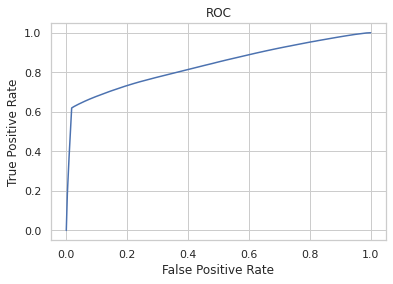

In [0]:
#running for LR
create_roc_curve(predictions)

***********************
TP = 205778, TN = 1089067, FP = 46315, FN = 116248
F2 = 0.6680249344726681
MCC = 0.6562137547712457
Balanced Accuracy = 0.7991090382695882
0.6680249344726681
***********************
/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(

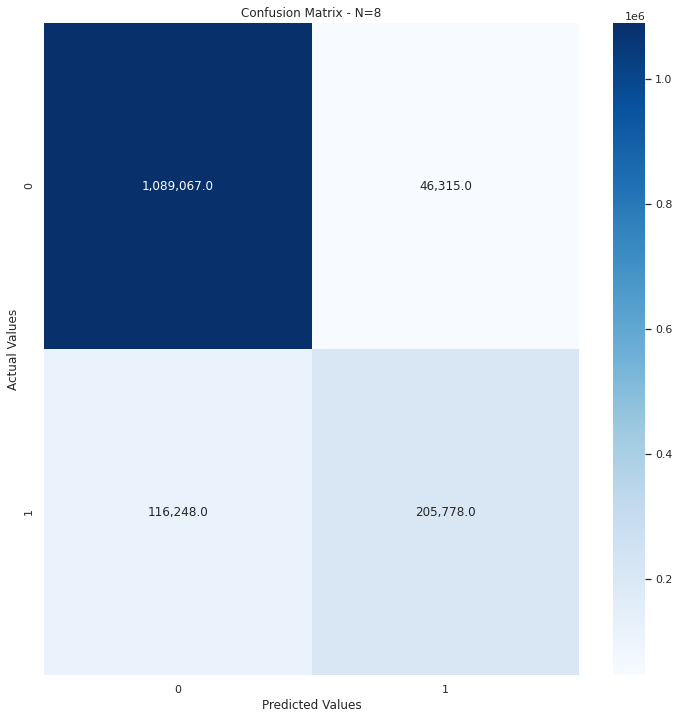

In [0]:
evaluate_model(predictions, 'Logistic Regression')

In [0]:
# Model pipeline
cat_features = ['OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat']
numeric_features = ['DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg']

categoricals = cat_features
numerics = numeric_features
myX = categoricals + numerics
myY = "DELAYED"

dt_train_ds_feature = train_df_resample.select(myX + [myY])
indexers = map(lambda c: StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep'), categoricals)
ohes = map(lambda c: OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class"),categoricals)
imputers = Imputer(inputCols = numerics, outputCols = numerics)

# Establish features columns
featureCols = list(map(lambda c: c+"_class", categoricals)) + numerics

# Build the stage for the ML pipeline
model_matrix_stages = list(indexers) + list(ohes) + [imputers] + \
                      [VectorAssembler(inputCols=featureCols, outputCol="features"), StringIndexer(inputCol="DELAYED", outputCol="label")]
    
# Apply StandardScaler to create scaledFeatures
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

    #print("Featured Columns ", featureCols)
    
dt_train_downsample = DecisionTreeClassifier(labelCol = "DELAYED", 
                                             featuresCol = "scaledFeatures",
                                             impurity = "gini", #'gini'
                                             maxDepth = 5, #5 
                                             maxBins = 32)

pipeline_dt = Pipeline(stages=model_matrix_stages+[scaler]+[dt_train_downsample])
model_dt = pipeline_dt.fit(dt_train_ds_feature)
predictions_dt = model_dt.transform(val_df)

In [0]:
model_eval(predictions_dt)

TP = 199454, TN = 1115535, FP = 19847, FN = 122572
F2 = 0.6615806634580621
MCC = 0.6984503931449509
Balanced Accuracy = 0.8009459442478558
Out[116]: 0.6615806634580621

In [0]:
dtModel = model_dt.stages[-1]
 
dt_feature_names = predictions_dt.schema["features"].metadata["ml_attr"]["attrs"]
dict_feature_names={}
for key in dt_feature_names.keys():
    for i in range(len(dt_feature_names[key])):
        dict_feature_names[dt_feature_names[key][i]['idx']]= dt_feature_names[key][i]['name']
featureNames = pd.DataFrame(list(dict_feature_names.items()),columns = ['index','name'])
featureNames
importance = dtModel.featureImportances
imp = pd.DataFrame(importance.toArray())

score
Out[128]:

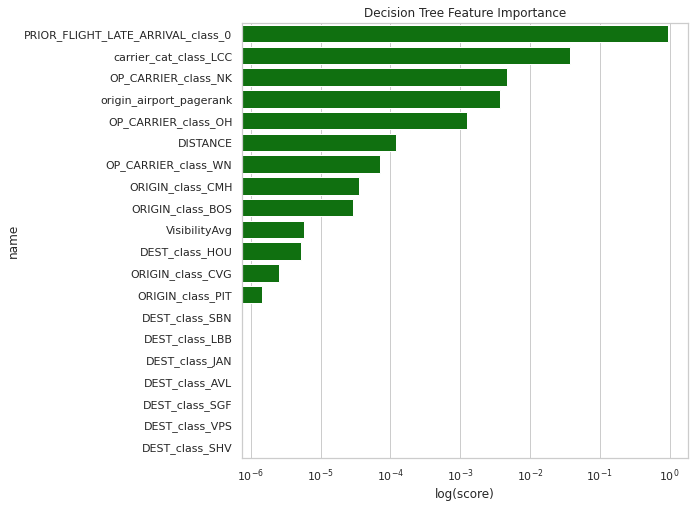

Text(0.5, 1.0, 'Decision Tree Feature Importance')

In [0]:
for col in imp.columns: 
    print(col) 
imp.rename( columns={0:'score'}, inplace=True )
df1 = imp.sort_values('score',ascending = False).head(20)
df1= df1.reset_index()
df2=pd.merge(featureNames, df1, on='index')
df2=df2.sort_values('score', ascending=False)
 
sns.set(font_scale=1, style='whitegrid')
plt.subplots(figsize=(8,8))
ax = sns.barplot(x='score', y='name', data=df2, color='green')
ax.set(xscale = 'log')
ax.set_xlabel('log(score)')
ax.set_title('Decision Tree Feature Importance')

***********************
TP = 199454, TN = 1115535, FP = 19847, FN = 122572
F2 = 0.6615806634580621
MCC = 0.6984503931449509
Balanced Accuracy = 0.8009459442478558
0.6615806634580621
***********************
/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(

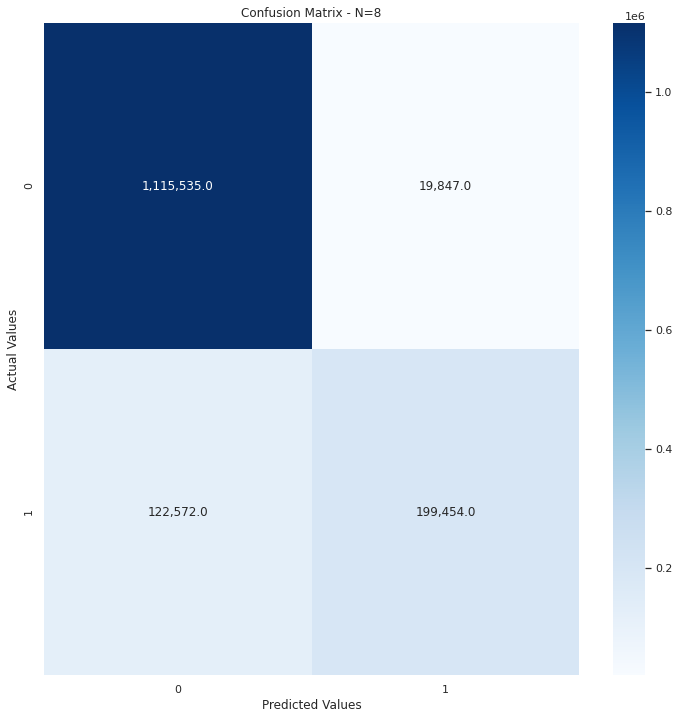

In [0]:
evaluate_model(predictions_dt, 'Decision Tree')    

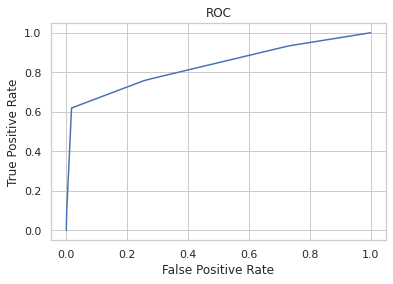

In [0]:
create_roc_curve(predictions_dt)

In [0]:
for col in imp.columns: 
    print(col) 
imp.rename( columns={0:'score'}, inplace=True )
df1 = imp.sort_values('score',ascending = False).head(20)
df1= df1.reset_index()
df2=pd.merge(featureNames, df1, on='index')
df2=df2.sort_values('score', ascending=False)
 
sns.set(font_scale=2, style='whitegrid')
plt.subplots(figsize=(16,14))
ax = sns.barplot(x='score', y='name', data=df2, color='green')
ax.set_xlabel('score')
ax.set_title('DT Feature Importance')

## Feature Selection

To remove irrelevant or less important features that do not contribute much to our target variable we reviewed feature importance from our Decision Tree model. This exercise highlighted features to keep. In the next phase we will reduce our feature list to the following:

 
#### Features to Keep
* PRIOR_FLIGHT_LATE_ARRIVAL
* carrier_cat
* OP_CARRIER
* origin_airport_pagerank
* DISTANCE
* ORIGIN
* DEST
* VisibilityAvg

## Results

| | Input features | F2 | Balanced Accuracy | MCC |
| --- | --- | --- | --- | --- |
| Train | OP_CARRIER, HOUR, MONTH, VisibilityAvg | 0.317 | 0.394 | -0.213 |
| Test | OP_CARRIER, HOUR, MONTH, VisibilityAvg | 0.227 | 0.392 | -0.161 |

Note: these numbers are slightly different from results in the video due to difference in the random undersampling

#### Logistic Regression
| | Input features | F2 | Balanced Accuracy | MCC |
| --- | --- | --- | --- | --- |
| Validation | 'OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat', 'DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg' | 0.668 | 0.799 | 0.656 | |

####  Decision Tree
| | Input features | F2 | Balanced Accuracy | MCC |
| --- | --- | --- | --- | --- |
| Validation | 'OP_CARRIER', 'DAY_OF_WEEK', 'MONTH', 'ORIGIN', 'DEST', 'HOLIDAY_IND', 'PRE_HOLIDAY_IND', 'POST_HOLIDAY_IND', 'PRIOR_FLIGHT_LATE_ARRIVAL', 'carrier_cat', 'DISTANCE', 'origin_airport_pagerank', 'WindSpeedAvg', 'VisibilityAvg' | 0.662 | 0.801 | 0.698 |

## Results and Gap Analysis

We attempted a cross validated logistic regression and decision tree hoping to improve on our initial baseline logistic regression. The baseline model was modeled on four variables: airline carrier, hour, month, and visibility average. The cross validated logistic regression and decision trees are modeled on additional features, including the feature engineered variables. These include: airline carrier, day of week, month, origin, dest, holiday indicators, prior flight information, and carrier categorization. Both cross validated models improved a lot on the baseline on all metrics. The baseline model showed very slight prediction power (better than random guessing) with F2 score at around 0.2 - 0.3 and balanced accuracy 0.4. However, the MCC on the baseline indicated some opposite predictions from actual. Our current models have more predictive power with F2 around 0.662. Balanced accuracy also improved to around 0.8 and MCC improved significantly to around 0.7 and is positive, indicating predictions in the correct direction. Our additional features and hyperparameter tuning successfully improved predictions. 

We also looked at the feature importance of the decision tree, and discovered that prior flight arrival information was most important for predicting flight delays, confirming our hypothesis. We also noticed other variables like the low-cost carrier categorization, pagerank airport importance, visibility, and certain origin airports are important to the model. 

For future model iterations, we plan to remove some less important variables to reduce dimensionality and potential overfitting. We also plan on adjusting thresholds for logistic regression to reduce false negatives (since we believe airports would rather predict more delays rather than have an unexpected delay to help with their planning operations) and also will attempt a random forest to further improve model predictions.

## Conclusion and Next Steps
In this phase, we intended to improve on the baseline model with feature engineering and cross validation so that we can better assist airport's delay planning. Our hypothesis is that ML pipelines with prior flight information can more accurately predict delays 2 hours prior to departure. In this section, we created new features to account for seasonality and airport business as well as the time-based prior flight information and tuned our logistic model with cross validation. The cross validated model with additional features improved on the baseline. The current models have F2 score around 0.67, balance accuracy around 0.8, and positive MCC around 0.7. We also started exploring tree models and will continue exploring and tuning them to further improve our predictions. We also plan to attempt random forest as well as do some additional feature selection. We also plan to update our custom CV function to save intermediate steps and adjust CV weights to give more weight to more recent data.

## Team Members and Phase 3 Responsibilities

* **Beijing Wu**: Cross Validation, Modeling, Grid Search 
* **Grace Lee**: Feature Engineering, Written Sections, Model Metrics
* **Shivangi Pandey**: Join, Feature Engineering, Modeling
* **Sybil Santos-Burgan**: Feature Engineering, Written Sections

<table>
<tr>
  <td>
    <figure>
    <img src="files/Beijing.jpg"  width="100" height="100">
    <div class="caption">Beijing</div>
    </figure>
  </td>
  <td>
    <figure>
    <img src="files/Shivangi.png"  width="100" height="100">
    <div class="caption">Shivangi</div>     
    </figure>
  </td>
  <td>
    <figure>
    <img src="files/Grace.jpg"  width="100" height="100">
    <div class="caption">Grace</div>
    </figure>
  </td>
  <td>
    <figure>
    <img src="files/Sybil.jpg"  width="100" height="100">
    <div class="caption" style="text-align: center;">Sybil</div>
    </figure>
  </td>
</tr>
</table>

##References

“Air Travel Consumer Report: Consumer Complaints Against Airlines Rise More than 300 Percent above Pre-Pandemic Levels.” Air Travel Consumer Report: Consumer Complaints Against Airlines Rise More Than 300 Percent Above Pre-Pandemic Levels | Bureau of Transportation Statistics, https://www.bts.dot.gov/newsroom/air-travel-consumer-report-consumer-complaints-against-airlines-rise-more-300-percent.

Duncan, Ian, and Lori Aratani. “Airlines Tried Shifting Blame, but They're the Biggest Cause of Delays.” The Washington Post, WP Company, 24 July 2022, https://www.washingtonpost.com/transportation/2022/07/23/airline-delays-summer-cancellations/. 
 
https://www.nytimes.com/2022/07/01/travel/summer-travel-flight-delays-cancellations.html

UnivariateFeatureSelector — PySpark 3.3.0 documentation, https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.UnivariateFeatureSelector.html.

United States. “Understanding the Reporting of Causes of Flight Delays and Cancellations.” Understanding the Reporting of Causes of Flight Delays and Cancellations , Bureau of Transportation Statistics, 20 Jan. 2022, https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations. 

US Domestic and International Delays and Cancellations Report, Flight Aware, https://public.tableau.com/app/profile/flightaware/viz/AirlineCancellationDelayUpdate/USAirlineCancellationsDelays.